# Пространственная автокорреляция  (индекс Морана I)

 **Цель:** определить районы с высоким доходом *Income*
 
 
*Income*  - Средний месячный доход на душу населения в рублях в районе


 **Этапы:**


- 1. Глобальная пространственная автокорреляция
- 2. Инкрементальная пространственная автокорреляция и пространственные веса
- 3. Анализ горячих точек

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import weights
import seaborn as sns

## Исходные таблицы

In [3]:
gdf = gpd.read_file("msk_dist.geojson")\

gdf = gdf.to_crs(32637)

gdf.head(1)

,fid,name_ao,name_dist,popul,area,Density,University,Income,Rent,mean_age,work_near,food_varie,area_per,shop_count,geometry
0,119.0,ЗАО,Можайский,142052,16916489,8397,29,71.91,217873,41.83,0.24,94,19.28,1.91,"MULTIPOLYGON (((398820.607 6173500.149, 398820..."


## Исследуемая характеристика (Income)

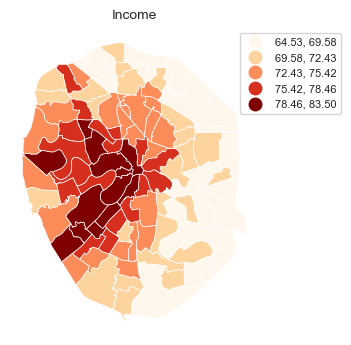

In [11]:
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize=(13, 4))

gdf.plot(column="Income", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.5, 
              cmap='OrRd', 
              legend=True,
              legend_kwds={"loc": "lower left", 
                           "bbox_to_anchor": (0.9, 0.7), 
                           "fontsize":"8"},
              ax = ax)


ax.set_title("Income", fontsize=10)
ax.set_axis_off()

# Remove all borders
sns.despine(bottom = True, left = True)
plt.show()

## 1. Глобальная пространственная автокорреляция

Есть ли пространственная автокорреляция?

### Пространственные веса

In [13]:
#выбираем пространственные веса на основе функций ядра с 8 ближайшими соседями
w_dist = weights.Kernel.from_dataframe(gdf, k=8, fixed=False, function = 'quadratic', distance_metric='euclidean')

for k in range(gdf.shape[0]):
    w_dist.weights[k][0]=0.0
    
w_dist.transform = 'r'

In [14]:
# минимальная полоса прпускания
w_dist.bandwidth.min()

3583.788162138667

### Глобальный индекс I Морана

In [41]:
from esda.moran import Moran

y = gdf['Income'].values

moran = Moran(y, w_dist)
moran.I

0.737779197098067

In [42]:
#z-оценка
moran.z_norm

13.427952553657656

In [43]:
#p-значение
moran.p_norm

0.0

Для оценки вероятности, что наблюдаемое размещение обусловлено полной пространственной случайностью, используем перестановки, применив метод Монте- Карло.

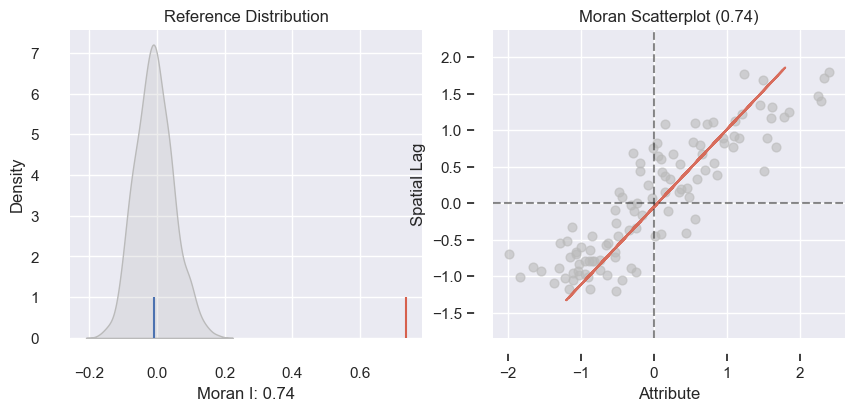

In [44]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

**Вывод:**  индекс I Морана получил значение **0.74**. Учитывая z-оценку **13.43** и p-значение 0.0, можно говорить о с высокой вероятностью, что распределение доходов склонно к группировке. Глобальный индекс I Морана помогает получить первое представление о группировке доходов. Однако он не позволяет определить местоположение групп. Более того, хотя мы рассчитали пространственную автокорреляцию, мы пока не определили подходящего масштаба анализа.

## 2. Инкрементальная пространственная автокорреляция и пространственные веса

Как определить масштаб анализа?

In [45]:
moran_all = []
moran_fix = []

for dist in range(4000,20000, 500):
    
#    print(dist)
    
    w_bdb = weights.distance.DistanceBand.from_dataframe(
        gdf, dist, binary=True, distance_metric='euclidean', radius=None)
    
    
    moran = Moran(y, w_bdb)
    
    moran_fix.append(dist)
    moran_fix.append(moran.I)
    moran_fix.append(moran.z_rand)
    moran_all.append(moran_fix)
    moran_fix = []
    

gm_dist = pd.DataFrame(data =moran_all,  columns = ['distance', 'Moran_I', 'z_score'])\
    .fillna(0)

gm_dist.head(5)

,distance,Moran_I,z_score
0,4000,0.720259,11.687968
1,4500,0.705655,13.194022
2,5000,0.700741,14.571721
3,5500,0.659622,15.426579
4,6000,0.636438,16.438019


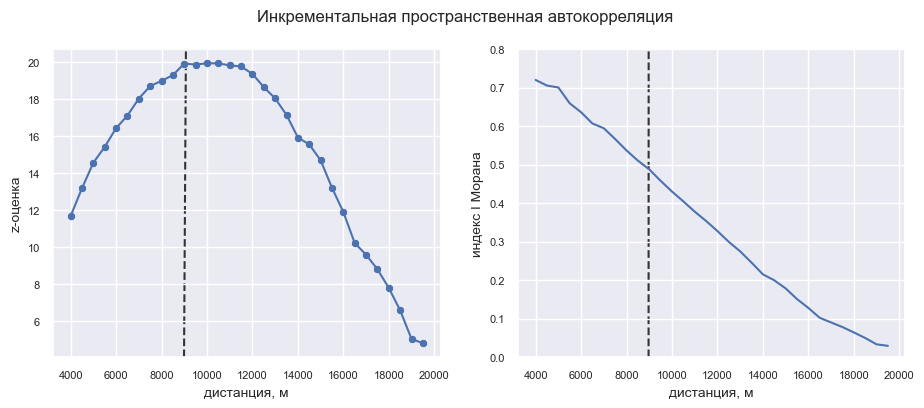

In [46]:
import seaborn as sns

sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

fig.suptitle("Инкрементальная пространственная автокорреляция", fontsize=12)

sns.scatterplot(data=gm_dist, x="distance", y="z_score", color = 'b', ax = axs[0])
sns.lineplot(data=gm_dist, x="distance", y="z_score", ax = axs[0])

axs[0].axline((9000, 6), slope=.2, c=".2",  ls="--", zorder=0, )



axs[0].set_xlabel('дистанция, м', fontsize=10)
axs[0].set_ylabel('z-оценка', fontsize=10)
axs[0].tick_params(labelsize=8)

sns.lineplot(data=gm_dist, x="distance", y="Moran_I", ax = axs[1])
axs[1].axline((9000, 6), slope=.2, c=".2",  ls="--", zorder=0)
axs[1].set_xlabel('дистанция, м', fontsize=10)
axs[1].set_ylabel('индекс I Морана', fontsize=10)
axs[1].set(ylim=(0, .8))
axs[1].tick_params(labelsize=8)

#plt.legend(loc = 'best')
plt.show()

**Вывод:** На графике наблюдается один пик, он соответствует расстоянию в **9000** м. Значения индекса I Морана для этого расстояния составляет **0.49** (с высокой z-оценкой), что указывает на интенсивную кластеризацию. Таким образом, в качестве масштаба анализа доходов можно выбрать расстояние в **9000** м. По полученным результатам мы можем заключить, что в исследуемой области имеют место пространственные автокорреляции доходов и лежащий в её основе процесс группировки.

## 3. Анализ горячих точек

Где наблюдается кластеризация доходов?

In [36]:
from esda.moran import Moran_Local
from  splot.esda  import  moran_scatterplot 

In [37]:
# задаём матрицу весов с полосой пропускания 9 км
w_dist_fix = weights.distance.DistanceBand.from_dataframe(gdf, 
                                                          9000, 
                                                          binary=True,  
                                                          distance_metric='euclidean', 
                                                          radius=None,
                                                          )

w_dist_fix.transform = 'r'

In [41]:
y = gdf['Income'].values
moran_loc = Moran_Local(y, w_dist_fix,  transformation = "r", permutations = 99)

In [58]:
# Локальные Индексы Морана I
gdf['ls'] = moran_loc.Is

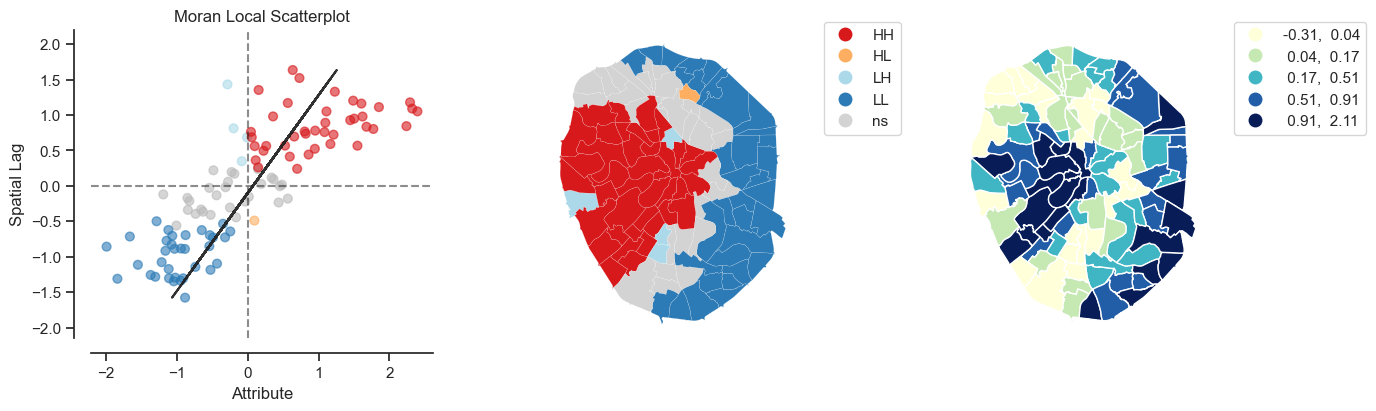

In [59]:
#HH - высокий-высокий
#HL - высокий-низкий
#LH - низкий-высокий
#LL - низкий-низкий

from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, gdf, 'ls', p=0.05)
plt.show()

**Интерпретация результатов:** если округ отличается высоким значением дохода и окружен округами с низкими доходами, то он отмечается как High-Low (Высокий-низкий). Если округ отличается низким значением дохода и окружен округами с высоким доходом, он отмечается как Low- High (Низкий-высокий). Если округа сгруппированы, они отмечаются как High-High (Высокий - высокий) в случае статистически значимых кластеров значений с высоким доходом и как Low-Low (Низкий-низкий) в случае статистически значимых кластеров значений с низким уровнем дохода.

В этом примере наблюдается положительная пространственная автокорреляция и статистически значимая кластеризация высоких доходов в центре города и на западе от него (с уровнем достоверности 95%). Иначе говоря, люди с высокими доходами, как правило, стремятся жить в красных районах, расположенных в центре города и на западе от него. Также был выявлен кластер низких значений в восточной части города. Кроме того, в исследуемой области обнаружились три выброса Low-High (Низкий-высокий) и один выброс High-Low (Высокий-низкий). Незначимые результаты (ns) указывают, что в соответствующих районах не наблюдается признаков кластеризации доходов.